In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim
import PIL
from PIL import Image
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pandas as pd
import seaborn
from facenet_pytorch import MTCNN
import mediapipe as mp
import cv2

In [28]:
print('torch :',torch.__version__)
print('cv2 :',cv2.__version__)
print('PIL :',PIL.__version__)

torch : 1.12.0+cpu
cv2 : 4.6.0
PIL : 9.2.0


In [2]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         #tt.Normalize((0.5), (0.5), inplace=True),
                         tt.Resize(64),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.Resize(64), tt.ToTensor()])

In [3]:
data_dir = './leapGestRecog/'

In [4]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['down', 'fist', 'ok', 'palm', 'thumb']
test Classes - ['down', 'fist', 'ok', 'palm', 'thumb']


In [5]:
digit_to_classname = {0:'down', 1:'fist', 2:'ok', 3:'palm', 4:'thumb'}

In [6]:
train_dataset = ImageFolder(data_dir + '/train', train_transforms)
test_dataset  = ImageFolder(data_dir + '/test', test_transforms)

In [7]:
batch_size = 32

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 64, 170])


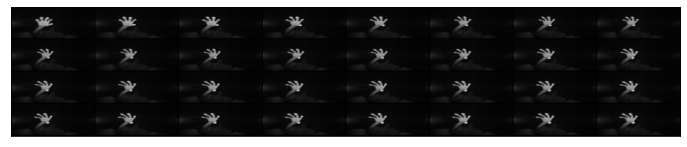

In [10]:
show_batch(test_dataloader)

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [12]:
len(classes_train)

5

In [16]:
device = get_default_device()
device

device(type='cpu')

In [17]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [18]:
class ResNet(nn.Module):
    def __init__(self, in_chnls, num_cls):
        super().__init__()
        
        self.conv1 = self.conv_block(in_chnls, 64, pool=True)           # 64x24x24 
        self.conv2 = self.conv_block(64, 128, pool=True)                # 128x12x12
        self.resnet1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))    # Resnet layer 1: includes 2 conv2d
        
        self.conv3 = self.conv_block(128, 256, pool=True)       # 256x6x6 
        self.conv4 = self.conv_block(256, 512, pool=True)       # 512x3x3
        self.resnet2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))    # Resnet layer 2: includes 2 conv2d
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Linear(512, num_cls))    # num_cls
        
    @staticmethod
    def conv_block(in_chnl, out_chnl, pool=False, padding=1):
        layers = [
            nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding),
            nn.BatchNorm2d(out_chnl),
            nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.resnet1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.resnet2(out) + out
#         print(out.shape)
#         print('*' * 20)
        return self.classifier(out)

In [19]:
model = to_device(ResNet(1, len(classes_train)), device)

In [20]:
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 20
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr)

In [21]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

20 epochs, 32 total_steps per epoch


In [22]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [ ]:
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = data, labels      
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
#         print('outputs', outputs[0])
#         print('labels', labels[0])
        _, preds = torch.max(outputs, 1)
        #print(preds)
        
        true_y.append(labels.to('cpu'))
        pred_y.append(outputs.to('cpu'))
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)